In [1]:
from PIL import Image
import numpy as np
import cv2
import os
import random
import time
# import tensorwatch as tw

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

from utils.dataset import *
import torch.utils.data as data

from vit_rollout import VITAttentionRollout

from utils.train import *
from utils.test  import *
from utils.CLS2IDX import CLS2IDX

In [2]:
# Training settings
epochs = 1
lr = 3e-6
gamma = 0.7
seed = 42
device = 'cpu'

file_Path = '/home/a611/Projects/Datasets/CSE_v1/images/'
train_name = ['/home/a611/Projects/Datasets/CSE_v1/labels/train.csv']
test_name = ['/home/a611/Projects/Datasets/CSE_v1/labels/test.csv']
num_classes = 11
num_input = 3
batch_size = 128
num_workers = 8
########################
os.chdir('examples')

In [3]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [4]:
# from tensorboardX import SummaryWriter
# writer = SummaryWriter('log') #建立一个保存数据用的东西
model = torch.load('../models/CSE_train.model')
# mask_model = torch.hub.load('facebookresearch/deit:main', 
#     'deit_tiny_patch16_224', pretrained=True)
mask_model = torch.load('../models/CSE_train_pretrained.model')
# model.head = nn.Linear(in_features = model.head.in_features, out_features = num_classes, bias = True)
model.to(device);
mask_model.to(device);

## Load Data

In [5]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

In [6]:
label_map = get_map(test_name)
label_key = list(label_map.keys())

In [7]:
def draw(x, output, input_type):
    output_max = output.argmax(dim=1)
    output_numpy = output.cpu().detach().numpy()
    fig, ax = plt.subplots(figsize=(12, 8))
    y = output_numpy[0]
    ax.bar(x = x, height = y)
    ax.set_title('Item: %s.' % x[int(output_max)], fontsize=15);
    xticks = ax.get_xticks()
    for i in range(len(y)):
        xy = (xticks[i], y[i])
        s = '%03f' % y[i]
        ax.annotate(
            text=s,  # 要添加的文本
            xy=xy,  # 将文本添加到哪个位置
            fontsize=8,  # 标签大小
            color="red",  # 标签颜色
            ha="center",  # 水平对齐
            va="baseline"  # 垂直对齐
        )
        plt.savefig("../results_%s.jpg" % input_type)
    return output_max

def result(x, output, input_type):
    output_max = output.argmax(dim=1)
    print('Input: %s; Item: %s.' % (input_type, x[int(output_max)]))
    return output_max

Input: origin; Item: doll.
Input: weight; Item: headset.
Input: origin; Item: container.
Input: weight; Item: headset.
Input: origin; Item: headset.
Input: weight; Item: headset.
Input: origin; Item: doll.
Input: weight; Item: headset.
Input: origin; Item: plant.
Input: weight; Item: headset.
Input: origin; Item: apple.
Input: weight; Item: headset.
Input: origin; Item: plant.
Input: weight; Item: headset.
Input: origin; Item: plant.
Input: weight; Item: headset.
Input: origin; Item: milk.
Input: weight; Item: headset.
Input: origin; Item: doll.
Input: weight; Item: headset.
Input: origin; Item: plant.


/tmp/ipykernel_1938874/4010640474.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(12, 8))


Input: weight; Item: headset.
Input: origin; Item: plant.
Input: weight; Item: headset.
Input: origin; Item: plant.
Input: weight; Item: doll.
Input: origin; Item: milk.
Input: weight; Item: doll.


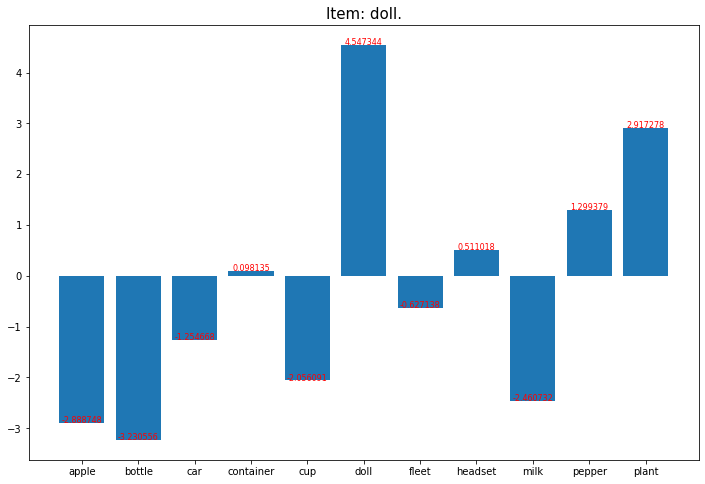

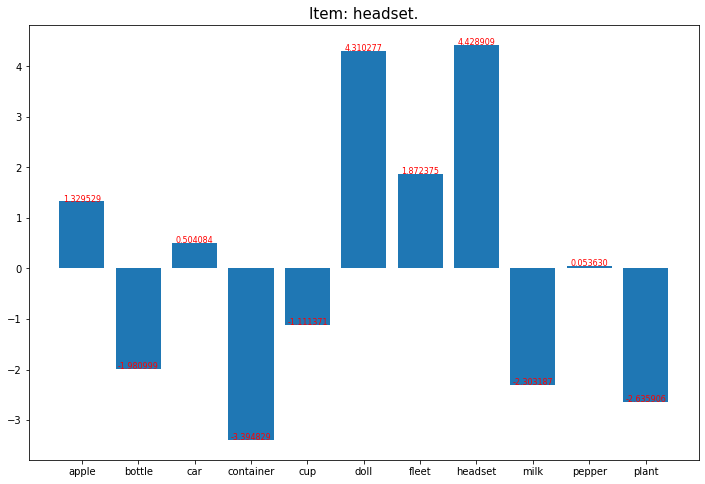

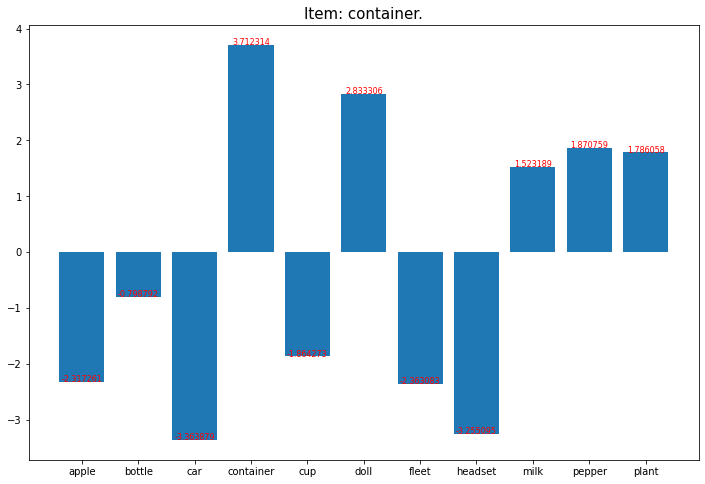

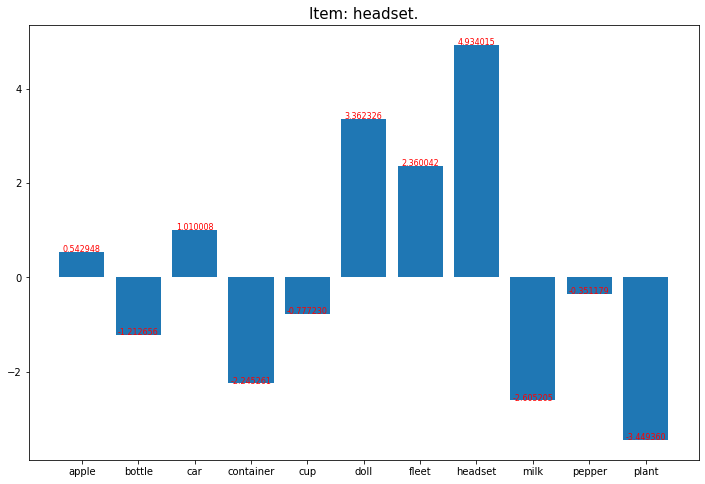

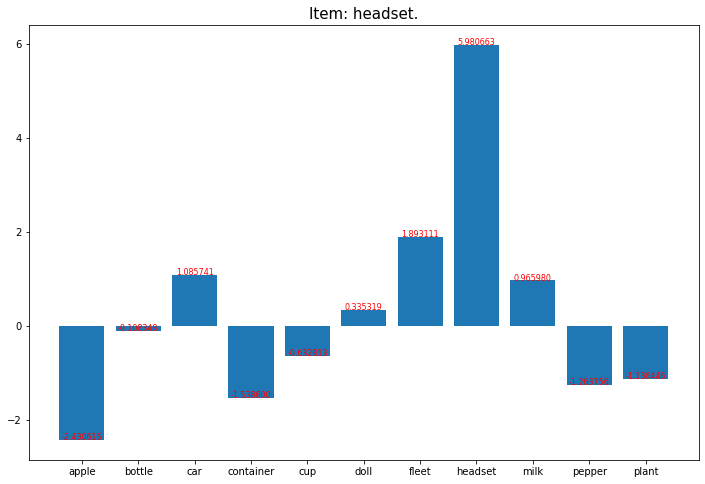

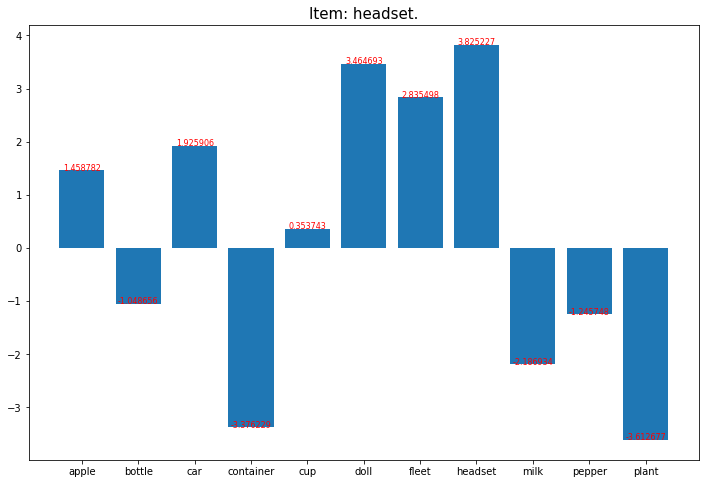

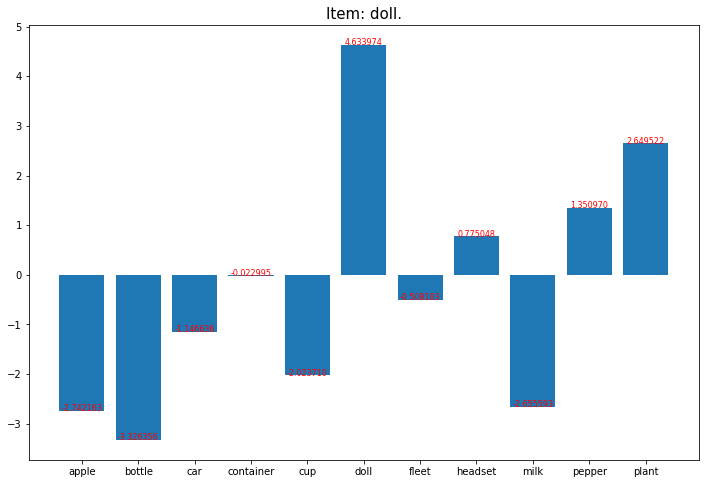

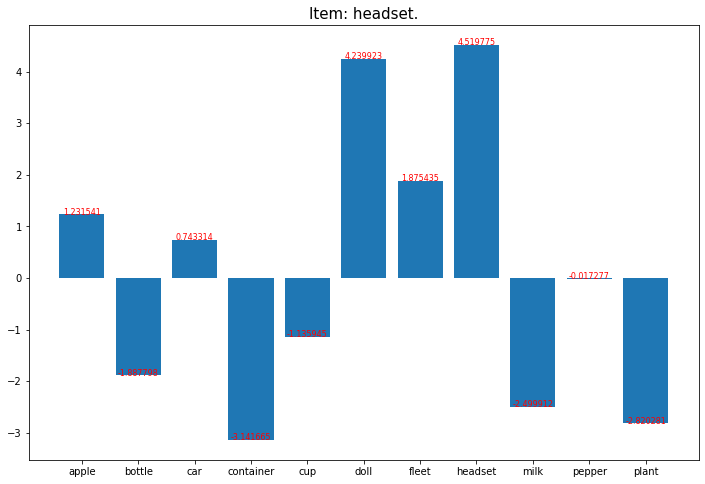

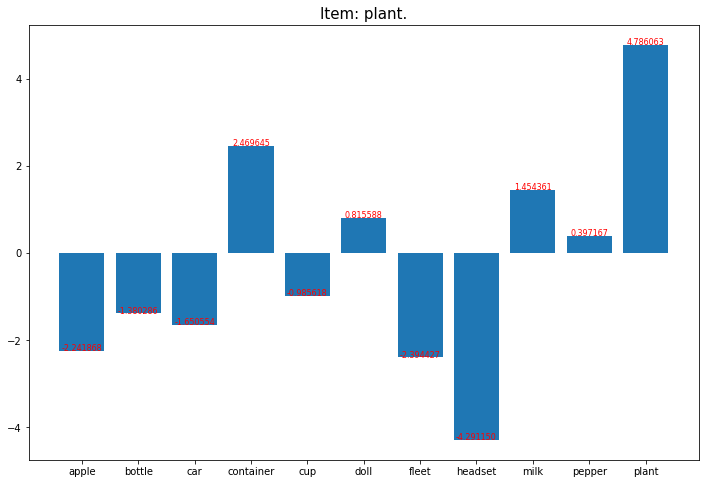

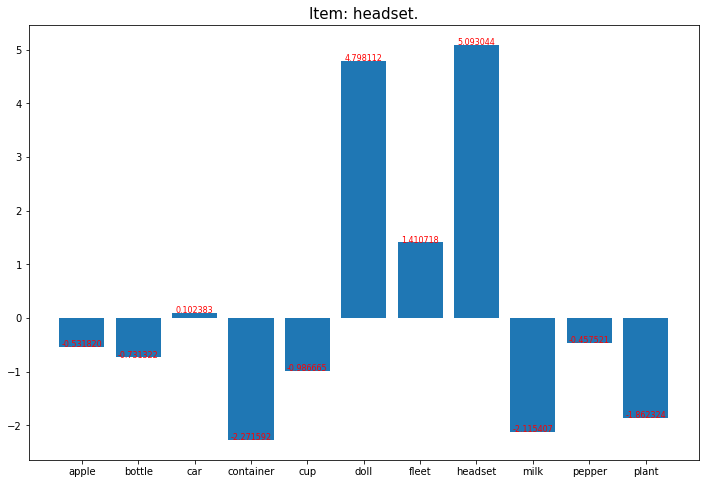

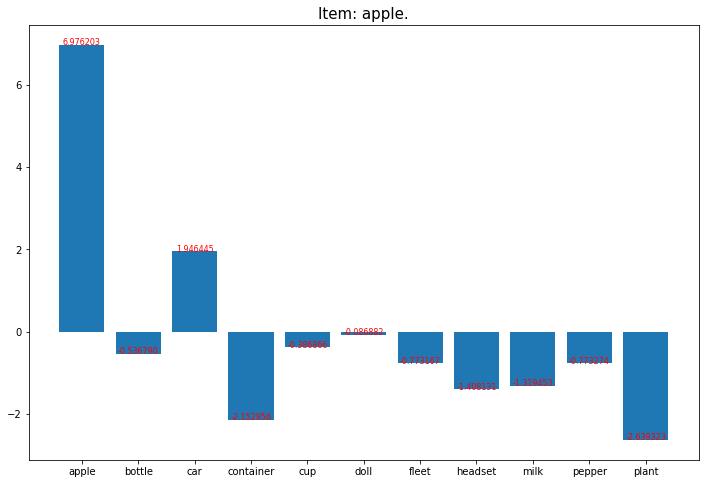

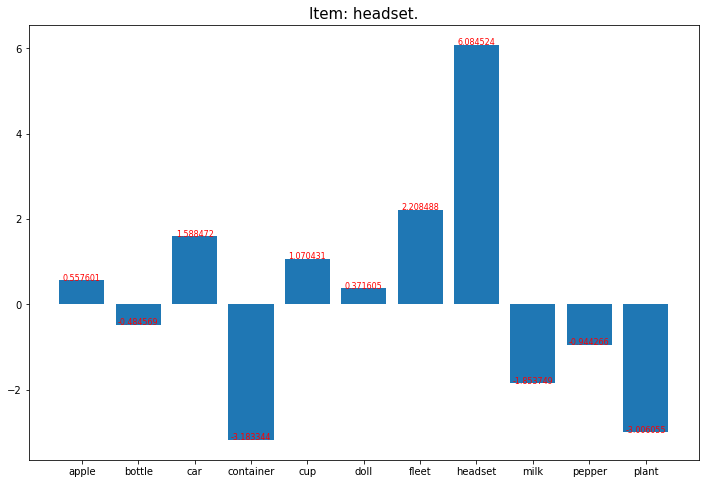

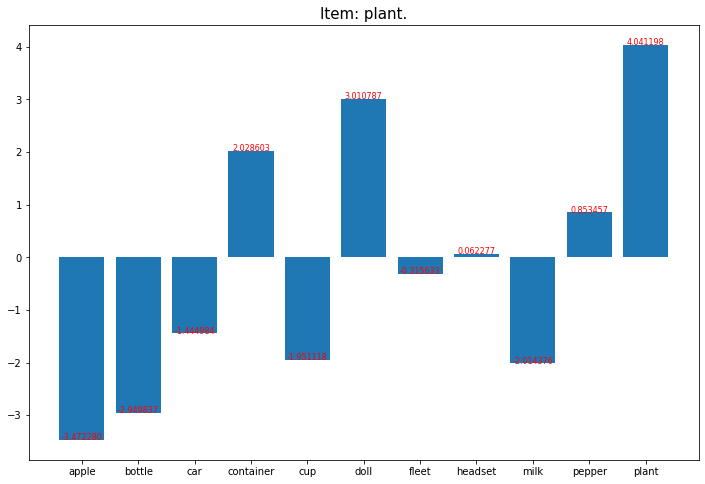

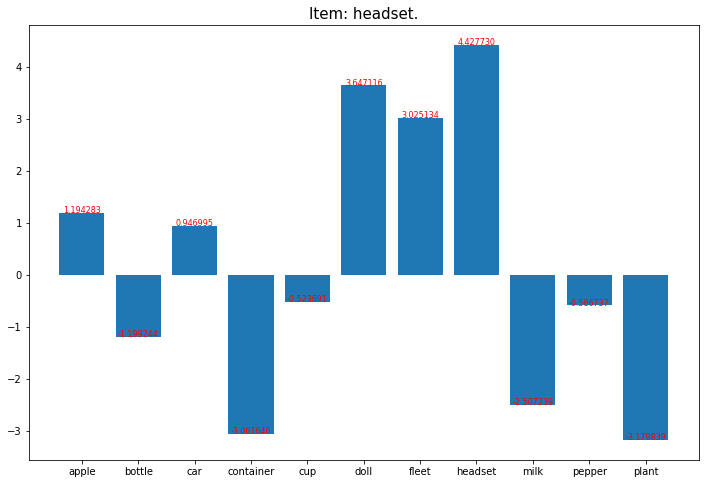

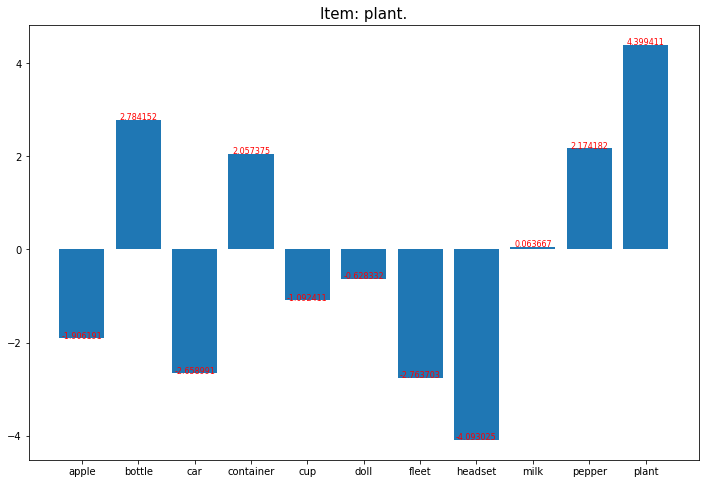

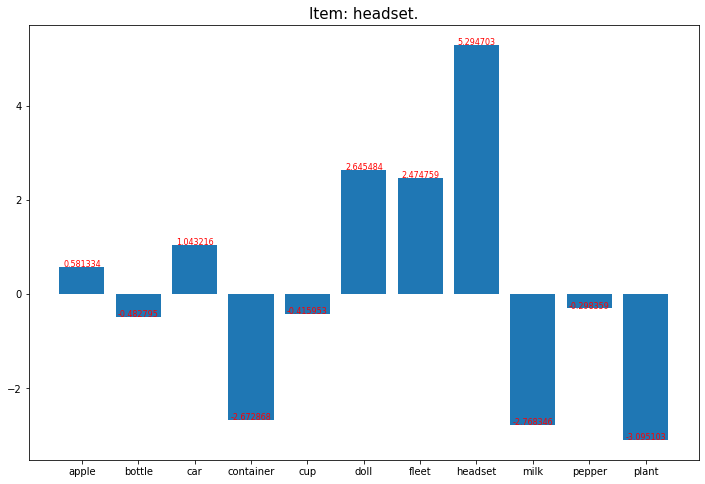

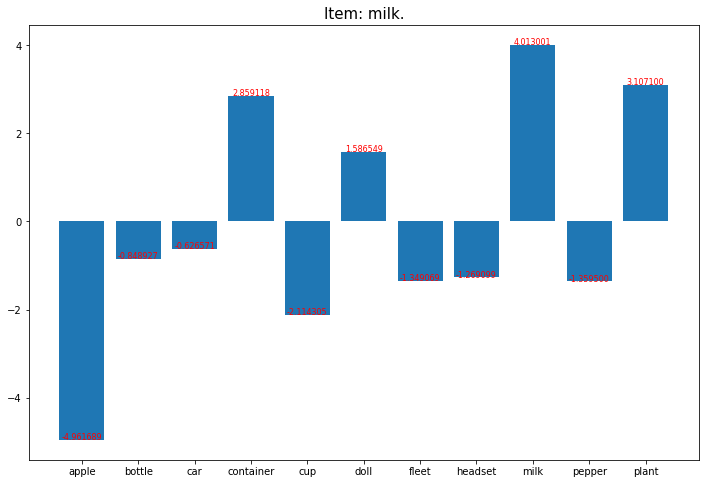

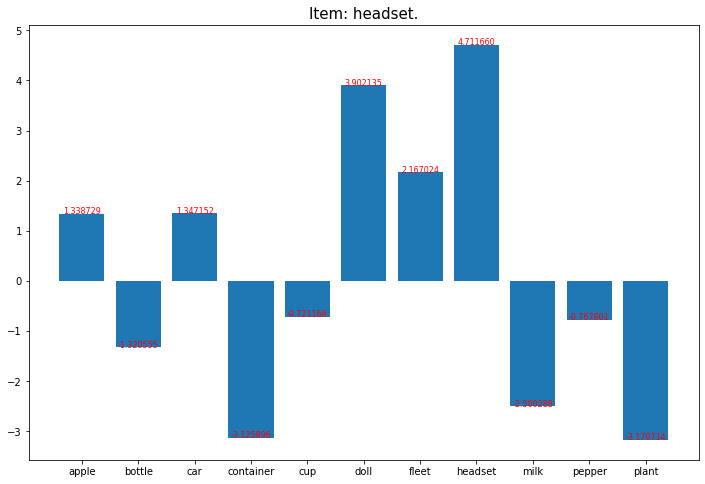

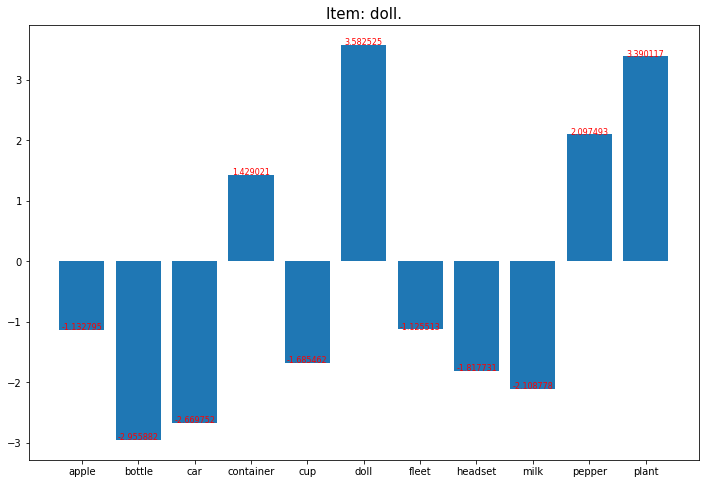

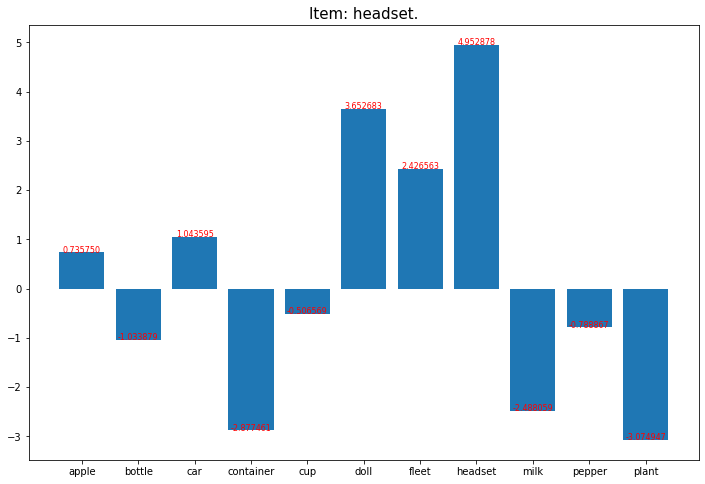

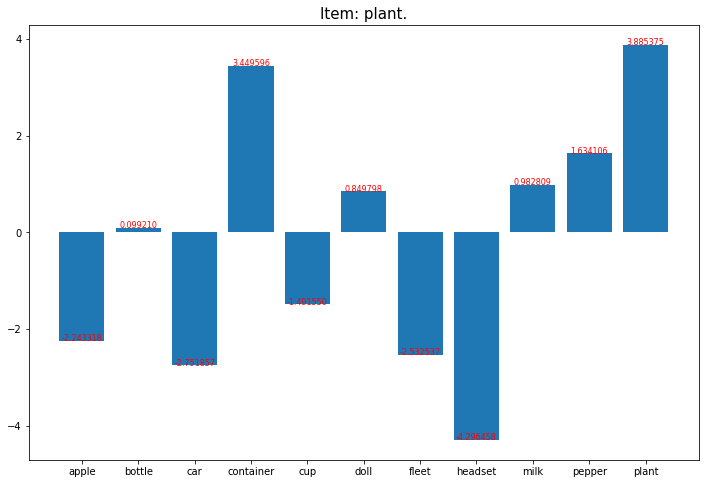

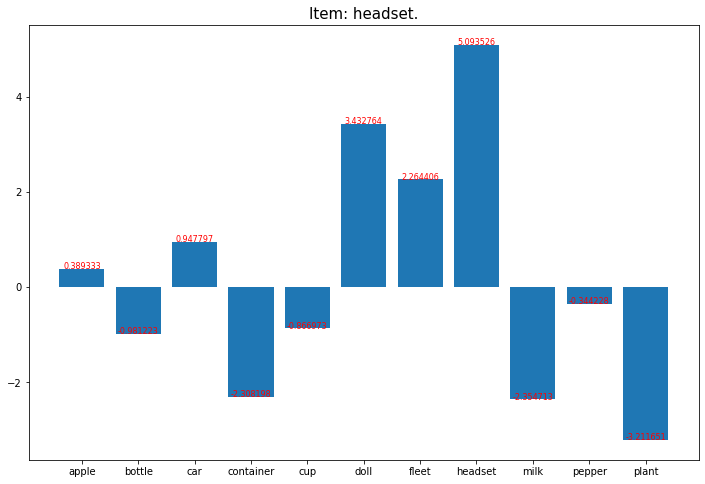

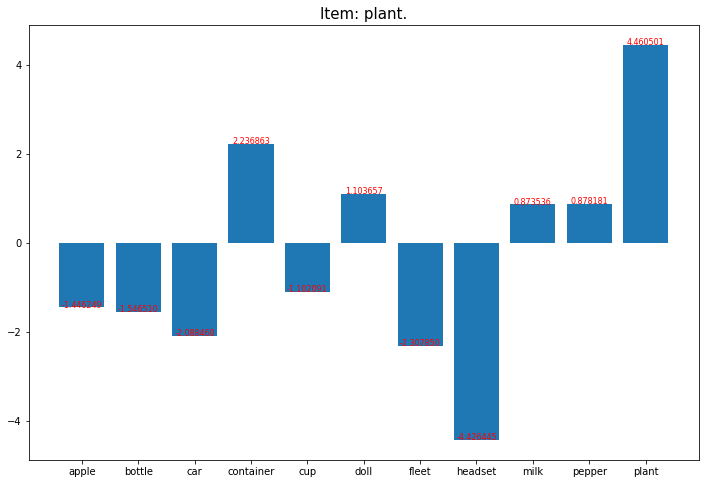

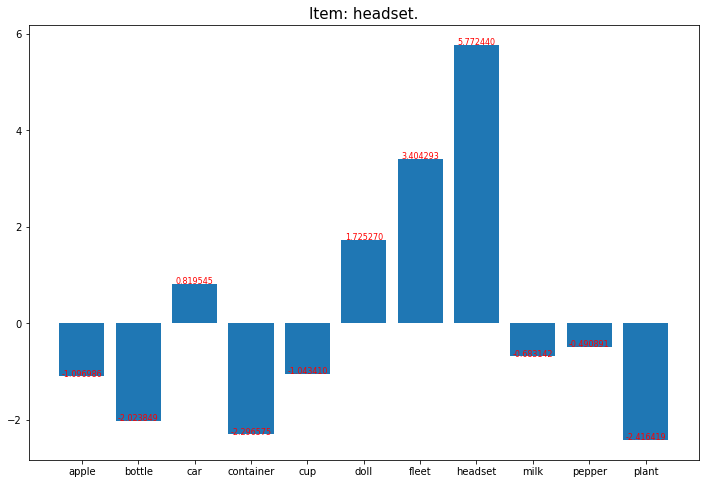

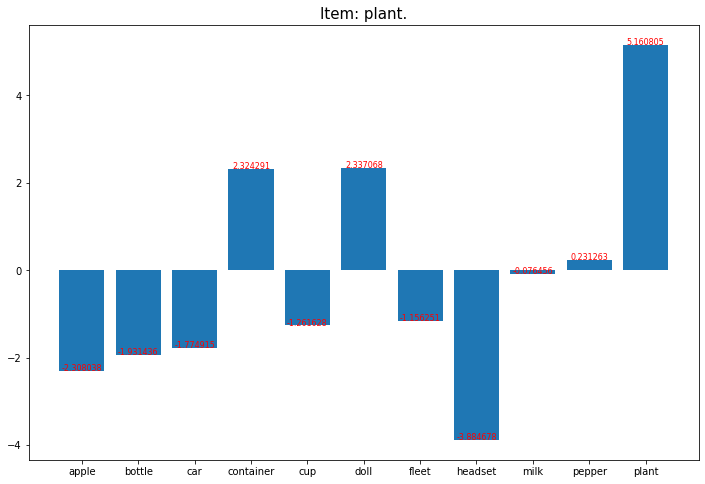

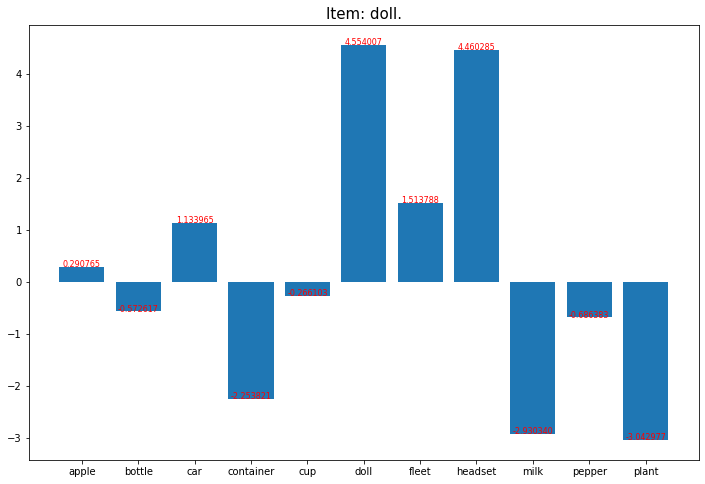

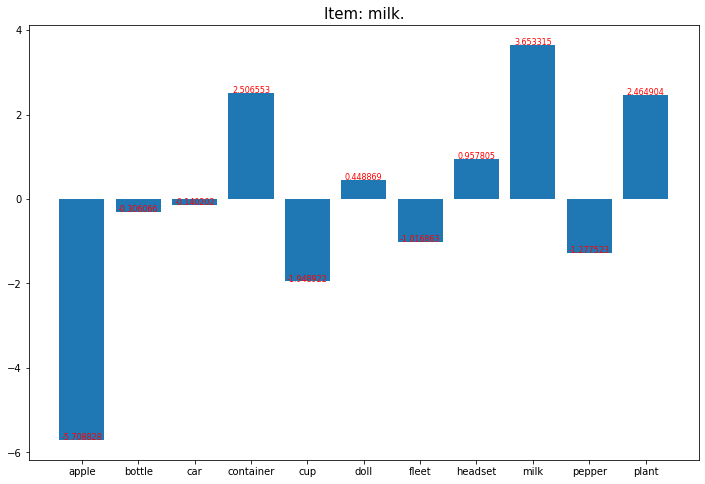

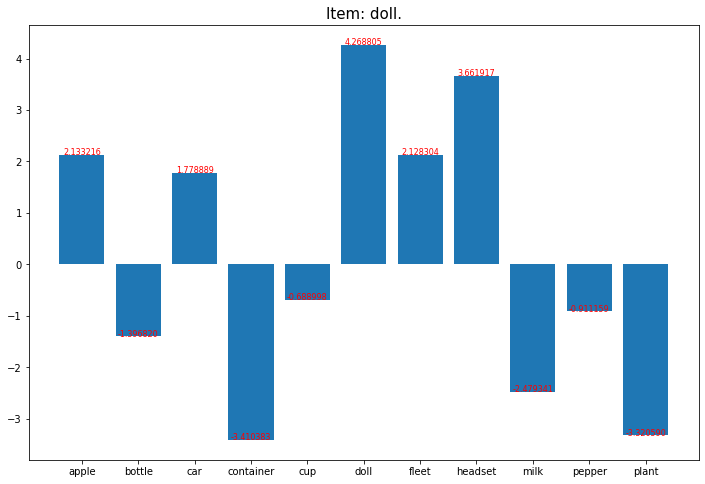

In [9]:
model.eval()
discard_ratio = 0.9
head_fusion = 'max'

weight_ratio = 1
Amp = 1.5

#########################################
for input_file_name in os.listdir('inputs'):
#     input_file_name = 'iPod_1.jpg'
    image_name = os.path.join('inputs',input_file_name)
    image = Image.open(image_name)
    img = image.resize((224, 224))
    input = test_transforms(image).unsqueeze(0)
    input = input.to(device)
    output = model(input)
    # output_max = draw(list(CLS2IDX.values()), output)
    output_max = result(label_key, output, 'origin')
    output_max = draw(label_key, output, 'origin')
    #########################################
    # How to fuse the attention heads for attention rollout. Can be mean/max/min.
    attention_rollout = VITAttentionRollout(mask_model, head_fusion = head_fusion, discard_ratio = discard_ratio)
    mask = attention_rollout(input)
    # name = "outputs/{}_{}_A-R_{:.3f}_{}.png".format(input_file_name.split('.')[0], label_key[int(output_max)], discard_ratio, head_fusion)
    output_name = "outputs/CSE-Pretrained/{}:{}.png".format(input_file_name.split('.')[0], label_key[int(output_max)])
    heatmap_name = "heatmaps/CSE-Pretrained/{}:{}.png".format(input_file_name.split('.')[0], label_key[int(output_max)])
    weight_name = "weights/CSE-Pretrained/{}:{}.png".format(input_file_name.split('.')[0], label_key[int(output_max)])
    #########################################

    np_img = np.array(image)[:, :, ::-1]
    mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
    mask_ = show_mask_on_image(np_img, mask)

    np_img_ = np.zeros(np_img.shape)
    for t in range(np_img.shape[2]):
        np_img_[:,:,t] = np_img[:,:,t] * (1 - weight_ratio + mask * weight_ratio * Amp)
        
    input_ = Image.fromarray(np.uint8(np_img_))
    input_ = test_transforms(input_).unsqueeze(0)
    input_ = input_.to(device)
    output_ = model(input_)
    output_max_ = result(label_key, output_, 'weight')
    output_max_ = draw(label_key, output_, 'weight')
    cv2.imwrite('../input.png', np_img);
    cv2.imwrite('../heatmap.png', mask * 255);
    cv2.imwrite(heatmap_name, mask * 255);
    cv2.imwrite('../output.png', mask_);
    cv2.imwrite(output_name, mask_);
    cv2.imwrite('../weight.png', np_img_);
    cv2.imwrite(weight_name, np_img_);
    
    time.sleep(2)